## Section 1: Data Cleaning


### Import datasets into project and join by shared columns


In [373]:
#Import OS for accesing system folders
import os as os

#Import Pandas for conversion of .csv into dataframes and usage of Pandas library
import pandas as pd
import numpy as np

In [374]:
#Set folder_path from our current directory
folder_path = os.getcwd()

#Update folder_path to Data/ folder to access .csv files
folder_path = os.path.join(folder_path, r'Data')

In [375]:
#Check that the files needed are in the folder
os.listdir(folder_path)

['2012_cleaned.csv', '2013_cleaned.csv', '2014_cleaned.csv']

Our first issue with these tables is that not all of them possess the same columns (only the names are the same). Therefore, we need to extract only the columns that all three tables have in common to avoid problems when merging into a bigger dataframe.

In [376]:
#Proof: columns are different for each .csv

#Loop through each file by name of files as in:
#['2012_cleaned.csv', '2013_cleaned.csv', '2014_cleaned.csv']
for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(current_file_path) #Convert the current .csv into a df to use Pandas columns() module
    print(file_name, "has", len(current_df.columns), "columns") #Check columns are not equal just by looking at amount of columns in each table

2012_cleaned.csv has 29 columns
2013_cleaned.csv has 28 columns
2014_cleaned.csv has 37 columns


Our first table has 29, our second 28, and our last one 37. When adding the tables, this will result in columns with many NA values. We must eliminate the "extra" columns first.

In [377]:
#Run a similar loop as above to created a nested list of all columns, to intersect later

columns_in_tables = []

for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(current_file_path)
    
    #Put all columns for each column in the list created above
    #Will look something like the following:
    #[[table1_column1][table1_column2],[table2_column1]...,[table3_column3]...]
    columns_in_tables.append(current_df.columns)

In [378]:
#For finding which columns are in every table we need to run an intersection
#Python does this by turning a nested list into a list of sets.

shared_columns = list(set.intersection(*map(set, columns_in_tables))) #* as in *args for multiple arguments input
#The map() function turns each element (sublist of columns) into a set which 
#We then turn the set back into a list and store it in shared_columns

In [379]:
#Modify the above for loop to put all tables in a single dataframe and select only shared_columns

data_merge = pd.DataFrame() #Initialize empty df 
dataframes = [] #Initialize empty list for use in pd.concat which accepts lists only

for file_name in os.listdir(folder_path):
    current_file_path = os.path.join(folder_path, file_name)
    current_df = pd.read_csv(current_file_path)
    dataframes.append(current_df)
    
data_merge = pd.concat(dataframes)
data_merge = data_merge[list(shared_columns)]

We can now see the columns we have to work with.

In [380]:
data_merge.columns

Index(['zip', 'stratum2', 'year_m', 'wave', 'pre_ele_97', 'psu',
       'mothe_house_income', 'birth_year', 'taiwanese_or_chinese', 'marriage',
       'taiwan_indep', 'gender', 'religion', 'month_income', 'pre_ele_101',
       'id', 'qtype', 'wsel', 'ssu', 'year', 'political_party', 'edu'],
      dtype='object')

And eliminate those which we don't need

In [381]:
data_merge = data_merge.drop(columns = ['zip', 'stratum2', 'year_m', 'wave', 'psu', 'wsel', 'id', 'qtype', 'ssu'])
data_merge.columns

Index(['pre_ele_97', 'mothe_house_income', 'birth_year',
       'taiwanese_or_chinese', 'marriage', 'taiwan_indep', 'gender',
       'religion', 'month_income', 'pre_ele_101', 'year', 'political_party',
       'edu'],
      dtype='object')

### Normalizing of variables in each column for easier navigation.

We now need to see which values columns have and normalize those values into simpler categories. For example: The political_party columns has the following values which, for this analysis, are too many.

In [336]:
data_merge['political_party'].value_counts()

political_party
都沒有___都支持      1165
都差不多           1115
都沒有/都支持         838
跳答              749
國民黨             605
民進黨             406
國民黨(跳答h7)       249
民進黨(跳答h7)       203
泛藍              131
泛綠              114
不知道              95
拒答               86
無黨籍(跳答h7)        41
有偏向政黨,不願意回答      21
親民黨              13
有支持政黨,但不回答       12
親民黨(跳答h7)        12
綠黨               12
台聯黨               9
其他政黨,請說明          8
新黨                7
新黨(跳答h7)          3
台聯(跳答h7)          2
建國黨               1
台聯                1
其他                1
Name: count, dtype: int64

Or the birth_year column has non-numeric values

In [348]:
data_merge['psu'].value_counts()

psu
1     898
2     868
3     849
4     568
6     416
5     393
9     241
11    232
7     231
12    227
10    227
8     210
13    207
14    203
Name: count, dtype: int64

In [337]:
data_merge.dtypes
#Int and floats are numeric while object are usually a combination of strings, ints, etc...

zip                      object
stratum2                 object
year_m                    int64
wave                      int64
pre_ele_97               object
psu                       int64
mothe_house_income       object
birth_year               object
taiwanese_or_chinese     object
marriage                 object
taiwan_indep             object
gender                   object
religion                 object
month_income             object
pre_ele_101              object
id                        int64
qtype                    object
wsel                    float64
ssu                     float64
year                      int64
political_party          object
edu                      object
dtype: object

In [338]:
#Let's extract columns where birth_year is only numbers...
#Run to_numeric to try and convert to number, if not possible then return NA, then use notnull to return non-NA values
# i.e. Return only numbers
data_merge = data_merge[pd.to_numeric(data_merge['birth_year'], errors = 'coerce').notnull()]
data_merge['birth_year'] = data_merge['birth_year'].astype('int')

We start by cleaning the political_party target column.

In [339]:
# Define the values to be replaced and the replacement string
data_merge.loc[data_merge['political_party'].isin(["民進黨(跳答h7)", "泛綠"]), 'political_party'] = '民進黨'
data_merge.loc[data_merge['political_party'].isin(["國民黨(跳答h7)", "泛藍"]), 'political_party'] = '國民黨'

#Change all other values to 'other'
data_merge.loc[~data_merge['political_party'].isin(['民進黨', '國民黨']), 'political_party'] = '其他'
data_merge['political_party'].unique()


array(['其他', '民進黨', '國民黨'], dtype=object)

Do a similar process for our ethnic identification column. From this:...

In [340]:
#Output all values of the ethnic identification category
data_merge['taiwanese_or_chinese'].unique()

array(['台灣人', '都是', '都不是', '中國人', '拒答', '不知道', '其他', '兩者都是', '兩者都不是,請說明',
       '無法決定', '兩者都是:是台灣人也是中國人', '兩者都是:是中國人也是台灣人', '都不是,請說明', '無法選擇',
       '不瞭解題意'], dtype=object)

To this:

In [341]:
non_other = ["台灣人", "都是", "兩者都是", "中國人", "兩者都是:是中國人也是台灣人", "兩者都是:是台灣人也是中國人", '兩者']

data_merge = data_merge[data_merge['taiwanese_or_chinese'].isin(non_other)] #Select only rows with the above values
data_merge.loc[~data_merge['taiwanese_or_chinese'].isin(["台灣人", "中國人"]), 'taiwanese_or_chinese'] = '兩者'

data_merge["taiwanese_or_chinese"].value_counts()


taiwanese_or_chinese
台灣人    3985
兩者     1641
中國人     144
Name: count, dtype: int64

For the other columns the process looks quite similar

In [342]:
data_merge['pre_ele_101'].value_counts()

data_merge.loc[data_merge['pre_ele_101'].str.contains('蔡英文') ,'pre_ele_101'] = '蔡英文'
data_merge.loc[data_merge['pre_ele_101'].str.contains('馬英九') ,'pre_ele_101'] = '馬英九'
data_merge.loc[~data_merge['pre_ele_101'].isin(['馬英九', '蔡英文']) ,'pre_ele_101'] = 'Other'
data_merge['pre_ele_101'].value_counts()

pre_ele_101
馬英九      2216
Other    1993
蔡英文      1561
Name: count, dtype: int64

In [344]:
data_merge.loc[data_merge['pre_ele_97'].str.contains('謝長廷') ,'pre_ele_97'] = '謝長廷'
data_merge.loc[data_merge['pre_ele_97'].str.contains('馬英九') ,'pre_ele_97'] = '馬英九'
data_merge.loc[~data_merge['pre_ele_97'].isin(['馬英九', '謝長廷']) ,'pre_ele_97'] = 'Other'
data_merge['pre_ele_97'].value_counts()

pre_ele_97
Other    3345
馬英九      1646
謝長廷       779
Name: count, dtype: int64

#### A quick visualization:

In [216]:
#Import our visualization tool Plotnine
from plotnine import *

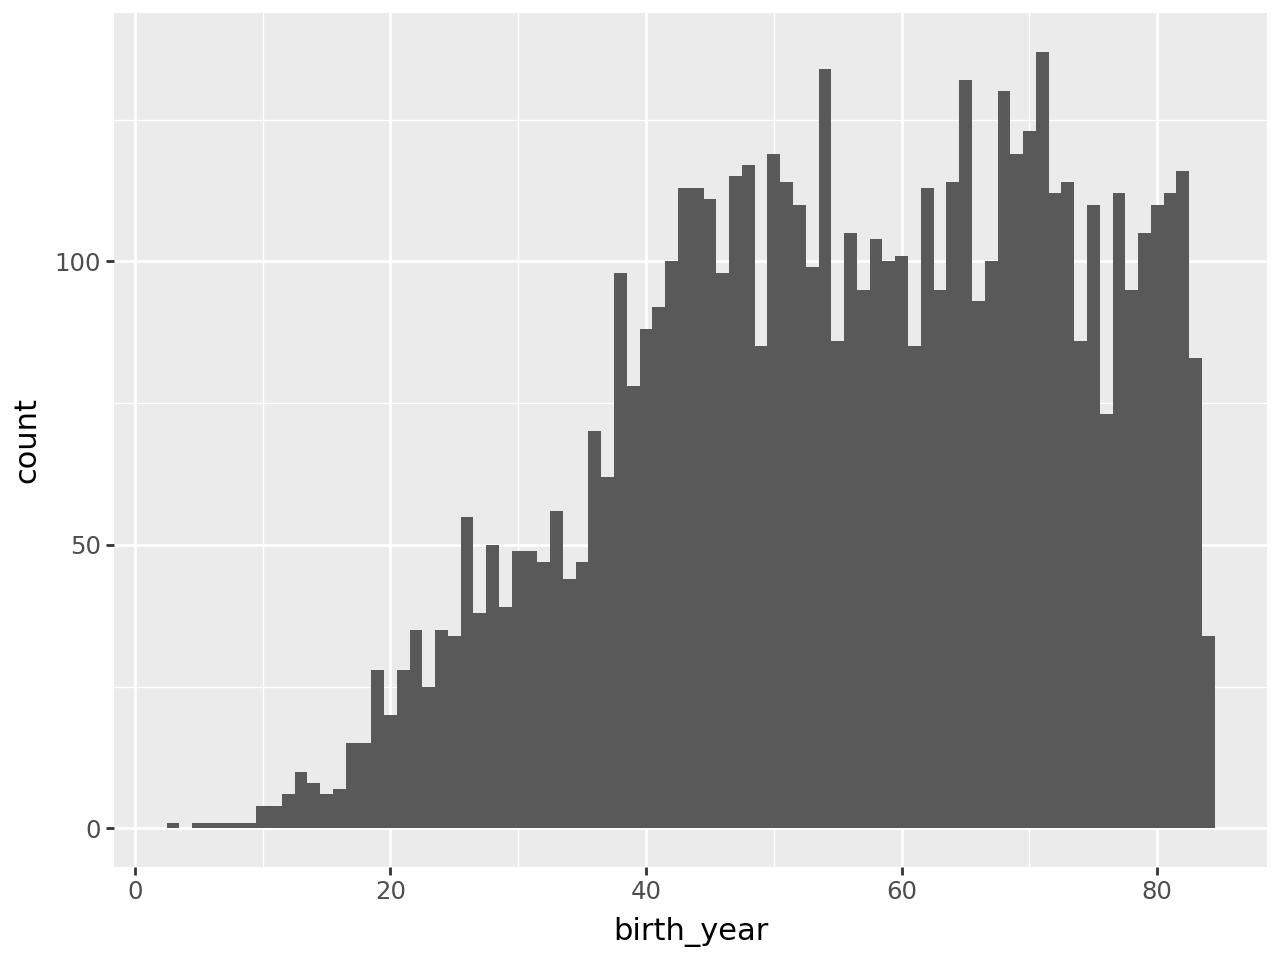

In [217]:
(
    ggplot()+
        geom_histogram(aes(x = data_merge['birth_year']), binwidth = 1)
)

## Section 2: Visualization